In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [2]:

input_dir = "../oof/"
oof0 = pd.read_csv(input_dir + "fold0_oof.csv")
oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,00204008d,0.011614,0.008457,0.042418,0.401096,0.008886,0.038326,0.000302,0.019317,...,0.003642,0.001088,0.000941,0.001326,0.632459,0.002985,0.002582,0.000796,0.000448,0.007304
1,1,00204008d,0.016388,0.008923,0.056771,0.493735,0.013346,0.026655,0.000385,0.046189,...,0.004984,0.001093,0.001084,0.001735,0.618683,0.003420,0.003138,0.001208,0.000412,0.006621
2,2,00204008d,0.006923,0.002970,0.018482,0.328682,0.003445,0.038184,0.000188,0.018724,...,0.002574,0.000606,0.000743,0.000879,0.617904,0.001537,0.006942,0.000238,0.000275,0.004057
3,3,00204008d,0.007631,0.004980,0.020792,0.356446,0.003240,0.036417,0.000281,0.012182,...,0.002670,0.000788,0.000723,0.001610,0.642056,0.002298,0.003062,0.000298,0.000322,0.009683
4,4,00204008d,0.007432,0.005515,0.018758,0.414864,0.006801,0.038041,0.000361,0.012685,...,0.003270,0.000881,0.000741,0.001546,0.656859,0.002671,0.002292,0.000464,0.000303,0.009437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,3,ffebe7313,0.001479,0.000835,0.000341,0.393871,0.168240,0.001813,0.000358,0.005459,...,0.019205,0.000555,0.001571,0.003121,0.003849,0.000183,0.008012,0.549763,0.000268,0.002762
7556,4,ffebe7313,0.003871,0.001984,0.000762,0.436470,0.523371,0.001701,0.000475,0.004703,...,0.005236,0.000808,0.003384,0.004495,0.031414,0.000128,0.003752,0.570920,0.000553,0.004289
7557,5,ffebe7313,0.003193,0.001829,0.000762,0.393509,0.527968,0.000948,0.000567,0.005428,...,0.008167,0.000840,0.002878,0.006129,0.022186,0.000150,0.005380,0.568162,0.000757,0.004793
7558,6,ffebe7313,0.001710,0.001171,0.000672,0.382518,0.451593,0.001443,0.000408,0.007830,...,0.013600,0.000829,0.002969,0.004746,0.012082,0.000116,0.005192,0.585980,0.000729,0.002841


In [3]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00204008d,7,0.016388,0.013396,0.059578,0.493735,0.013346,0.049699,0.000563,0.046189,...,0.004984,0.001408,0.001441,0.001772,0.656859,0.019512,0.006942,0.001208,0.000448,0.009683
1,003b04435,7,0.006491,0.271558,0.817263,0.582187,0.001000,0.011136,0.000457,0.507924,...,0.003398,0.012017,0.004618,0.001564,0.021288,0.001948,0.006135,0.003078,0.001999,0.018897
2,003bec244,7,0.016653,0.092692,0.004111,0.796572,0.001122,0.056808,0.001055,0.731429,...,0.530324,0.024477,0.012449,0.001183,0.035902,0.000177,0.004752,0.002330,0.000824,0.006857
3,005f1f9a5,7,0.001806,0.562375,0.008872,0.663232,0.003188,0.017574,0.001324,0.484974,...,0.012036,0.004174,0.010937,0.009507,0.004279,0.000360,0.006413,0.059199,0.000566,0.007846
4,006ab765f,7,0.000365,0.003948,0.000931,0.152026,0.003237,0.016949,0.000634,0.008062,...,0.000912,0.002467,0.000131,0.002680,0.005917,0.000299,0.009291,0.003433,0.000515,0.663724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,7,0.006120,0.032910,0.018384,0.859597,0.008144,0.001249,0.020532,0.605389,...,0.038716,0.631085,0.012623,0.141294,0.029293,0.004813,0.108453,0.005453,0.005531,0.003068
4723,ffd88cd84,7,0.678242,0.816080,0.019730,0.773883,0.003236,0.002072,0.003604,0.004051,...,0.018712,0.602858,0.001565,0.000655,0.252100,0.000488,0.003942,0.012082,0.000500,0.174276
4724,ffebe7313,7,0.004149,0.001984,0.001627,0.436470,0.530631,0.003328,0.000720,0.010481,...,0.019205,0.001038,0.005087,0.007669,0.031789,0.000195,0.008012,0.608263,0.000888,0.006123
4725,fff163132,7,0.000787,0.002458,0.006591,0.403609,0.014164,0.002721,0.001389,0.006708,...,0.006681,0.000450,0.000785,0.292260,0.023696,0.000264,0.262202,0.007496,0.000461,0.030455


In [4]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v >= 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [5]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.016653,0.092692,0.004111,0.796572,0.001122,0.056808,0.001055,0.731429,...,0.530324,0.024477,0.012449,0.001183,0.035902,0.000177,0.004752,0.002330,0.000824,0.006857
1,006ab765f,7,0.000365,0.003948,0.000931,0.152026,0.003237,0.016949,0.000634,0.008062,...,0.000912,0.002467,0.000131,0.002680,0.005917,0.000299,0.009291,0.003433,0.000515,0.663724
2,007f87ba2,7,0.003203,0.008519,0.011937,0.862373,0.567433,0.003278,0.003308,0.005812,...,0.002405,0.001714,0.002139,0.003682,0.688001,0.000247,0.002553,0.027197,0.000318,0.025265
3,0099c367b,7,0.037288,0.018506,0.000222,0.173127,0.005766,0.000737,0.025520,0.003990,...,0.004902,0.169730,0.000384,0.374681,0.024755,0.000219,0.007071,0.006334,0.000345,0.055700
4,009b760e6,7,0.000968,0.009766,0.001056,0.148117,0.001685,0.000554,0.000456,0.031990,...,0.001431,0.001565,0.000145,0.005482,0.008649,0.004634,0.005465,0.004336,0.000228,0.491026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,7,0.003895,0.151430,0.005520,0.637834,0.003531,0.017147,0.001121,0.003331,...,0.000649,0.000984,0.216288,0.001517,0.007481,0.003466,0.001071,0.049117,0.000124,0.041960
1128,fea6b438a,7,0.002897,0.035084,0.003498,0.831059,0.455140,0.002065,0.000492,0.014096,...,0.008529,0.002191,0.395022,0.000661,0.054866,0.000434,0.007863,0.226282,0.000292,0.071865
1129,ff2eb9ce5,7,0.755709,0.001379,0.028417,0.622017,0.053907,0.002350,0.000635,0.002218,...,0.006693,0.001498,0.000375,0.001007,0.895338,0.000399,0.000982,0.002200,0.000195,0.033195
1130,ffb8d8391,7,0.047012,0.029309,0.004060,0.761696,0.001772,0.012570,0.000447,0.006067,...,0.016281,0.248883,0.000384,0.000253,0.858559,0.000384,0.000277,0.007440,0.000306,0.058722


In [6]:
tp2 = tp2[tp2["recording_id"].isin(tp_oof["recording_id"])]

In [7]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [8]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.98316081, 0.9636414 , 0.99355717, 0.68092421, 0.94731978,
       0.96547135, 0.99259427, 0.92669131, 0.97598891, 0.99112141,
       0.98969228, 0.95719039, 0.95497227, 0.9957671 , 0.98380776,
       0.96297676, 0.99105217, 0.96789279, 0.917061  , 0.9969596 ,
       0.97611668, 0.95473198, 0.9935244 , 0.97575176])

<BarContainer object of 24 artists>

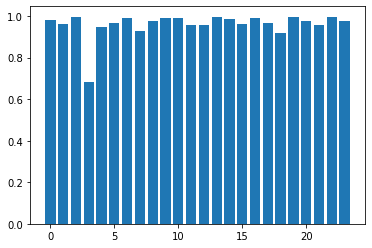

In [9]:
plt.bar(np.arange(24), auc)

In [10]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([1132, 24]), torch.Size([1132, 24]))

In [11]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.711670994758606